In [3]:
#!pip install -r requirements.txt

In [4]:
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sklearn.metrics import confusion_matrix

C:\Users\User\AppData\Local\Temp\ipykernel_25056\229508138.py:3: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask con

## Daten aus Datenbank laden

In [5]:
#variablen für die Datenbankverbindung
benutzer = "production1"
passwort = "production42!"
server = "195.20.227.20"
db = "production1"
port = 32771
#Datenbankverbindung
datenbank = mysql.connector.connect(
    host = server,
    user = benutzer,
    password = passwort,
    database = db,
    port = port,
    auth_plugin = 'mysql_native_password',
    connect_timeout=100000
)


In [6]:
#laden der strukturierten Daten aus Datenbank und speichern in Dataframe
data = pd.read_sql_query("SELECT * FROM wartung", datenbank)

C:\Users\User\AppData\Local\Temp\ipykernel_25056\2432445196.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query("SELECT * FROM wartung", datenbank)


In [7]:
data =dd.from_pandas(data, npartitions=8)

## Daten aufbereiten

In [8]:
#Datentypen ausgeben
print(data.info())

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, MesswertID to Produktionsindex
dtypes: float64(4), int64(3), string(3)None


In [9]:
#Anzahl Nullwerte
print("Datentypen:")
print(data.isnull().sum())

Datentypen:
Dask Series Structure:
npartitions=1
Anzahlwarning    int64
Zeit               ...
dtype: int64
Dask Name: to_pyarrow_string, 6 graph layers


In [10]:
#Datensätze mit Duplikaten entfernen
data.drop_duplicates()
print(data.info())


<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, MesswertID to Produktionsindex
dtypes: float64(4), int64(3), string(3)None


In [11]:
print(data.head())

   MesswertID MaschinenID       Datum   Zeit    Druck  Temperatur  Vibration  \
0       12478          A1  01.02.2022  06:00  47.6190     61.9048    28.5714   
1       12479          A1  01.02.2022  06:05  48.5714     62.8571    47.6190   
2       12480          A1  01.02.2022  06:10  57.1429     76.1905    33.3333   
3       12481          A1  01.02.2022  06:15   0.0000      0.0000     0.0000   
4       12482          A1  01.02.2022  06:20   0.0000      0.0000     0.0000   

   Anzahlwarning  Ausschuss  Produktionsindex  
0              3        2.0                85  
1              5        3.0                87  
2             12       11.0                91  
3              2        0.0                84  
4              2        0.0                85  


### Fehlerhafte Daten  beim Datum identifizieren und korrigieren

In [12]:
#konvertieren von Datum in datetime und entfernen von Uhrzeit und Zeitzone
data['Datum'] = dd.to_datetime(data['Datum'], format='%d.%m.%Y', errors='coerce').dt.date
print(data.info())

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, MesswertID to Produktionsindex
dtypes: float64(4), int64(3), string(3)None


In [13]:
#konvertieren von Zeit in Datetime, wenn Wert nicht nutzbar dann NaN
data['Zeit'] = dd.to_datetime(data['Zeit'], format='%H:%M', errors='coerce').dt.time
d1 = data.copy()

### Neue Ausfall Spalte hinzufügen

In [14]:
#neue Spalte Ausfall hinzufügen
d1 = d1.assign(Ausfall=lambda x: ((x['Druck'] == 0) & (x['Temperatur'] == 0) & (x['Vibration'] == 0) & (x['Ausschuss'] == 0)).astype(int))
d2 = d1.copy()

In [15]:
print(d2.dtypes)

MesswertID                    int64
MaschinenID         string[pyarrow]
Datum               string[pyarrow]
Zeit                string[pyarrow]
Druck                       float64
Temperatur                  float64
Vibration                   float64
Anzahlwarning                 int64
Ausschuss                   float64
Produktionsindex              int64
Ausfall                       int32
dtype: object


In [16]:
#Neue Spalte für fehlerhafte Werte hinzufügen
d2['Error'] = (
    (d2['Ausfall'] == 0) & 
    ((d2['Druck'] == 0) | (d2['Temperatur'] == 0) | (d2['Vibration'] == 0))
).astype(int)

# Anzahl der fehlerhaften Werte berechnen
error_counts = d2['Error'].value_counts().compute()

# Ausgabe der Anzahl der fehlerhaften Werte
print(error_counts)


Error
0    1065
1      30
Name: count, dtype: int64


In [17]:
#30 errors können gelöscht werden, da unter 1% der Daten
d2_filtered = d2[d2['Error'] == 0]
columns_to_keep = [col for col in d2_filtered.columns if col != 'Error']

d2 = d2_filtered[columns_to_keep]


print(d2.compute().info())


<class 'pandas.core.frame.DataFrame'>
Index: 1065 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1065 non-null   int64  
 1   MaschinenID       1065 non-null   string 
 2   Datum             1056 non-null   string 
 3   Zeit              1056 non-null   string 
 4   Druck             1065 non-null   float64
 5   Temperatur        1065 non-null   float64
 6   Vibration         1065 non-null   float64
 7   Anzahlwarning     1065 non-null   int64  
 8   Ausschuss         1065 non-null   float64
 9   Produktionsindex  1065 non-null   int64  
 10  Ausfall           1065 non-null   int32  
dtypes: float64(4), int32(1), int64(3), string(3)
memory usage: 116.4 KB
None


In [18]:
#In der Datumsspalte gibt es leere Werte da diese nicht in einem gültigen Format sind. Diese Zeilen können gelöscht werden, da sie nur 0,1% der Daten ausmachen (alternativ könnte man die Annahme treffen, dass diese, da am ende dem 08.02. zugeordnet werden können (input))
def filter_non_na(d2):
    return d2[d2['Datum'].notna()]

#'map_partitions' verwenden, um die Funktion auf jede Partition des Dask DataFrames anzuwenden
d2_filtered = d2.map_partitions(filter_non_na)

#Überprüfen des Typs nach dem Filtern
print(type(d2_filtered))

<class 'dask.dataframe.core.DataFrame'>


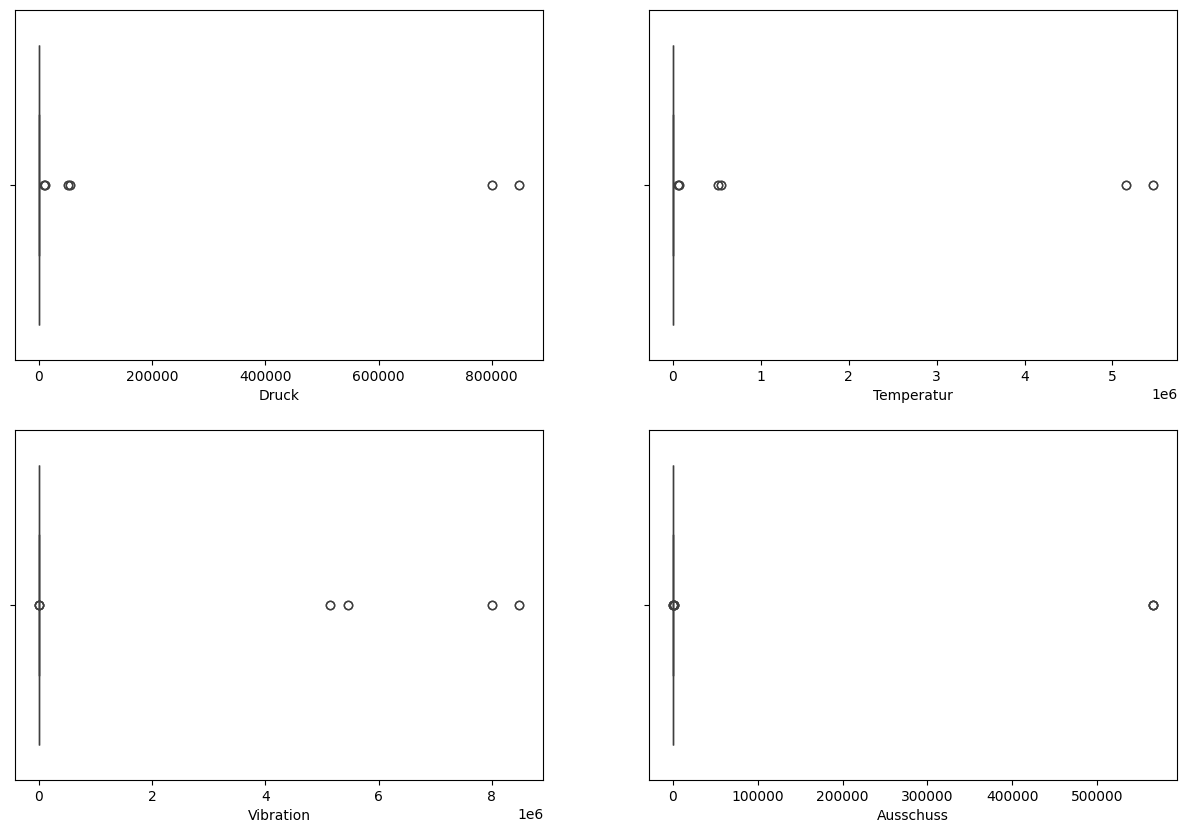

In [19]:
#Die spalten in Pandas Serie umwandeln damit sns boxplot funktioniert
druck = d2['Druck'].compute()
temperatur = d2['Temperatur'].compute()
vibration = d2['Vibration'].compute()
ausschuss = d2['Ausschuss'].compute()

#Boxplots für die Spalten erstellen
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=druck, ax=ax[0, 0])
sns.boxplot(x=temperatur, ax=ax[0, 1])
sns.boxplot(x=vibration, ax=ax[1, 0])
sns.boxplot(x=ausschuss, ax=ax[1, 1])

plt.show()


In [20]:
print(type(d2))

<class 'dask.dataframe.core.DataFrame'>


In [21]:
#Ausreißer entfernen
condition = (d2['Druck'] < 100) | (d2['Druck'].isna())

#Filtern des DataFrames basierend auf der Bedingung
d2_filtered = d2[condition]
d2 = d2_filtered.copy()


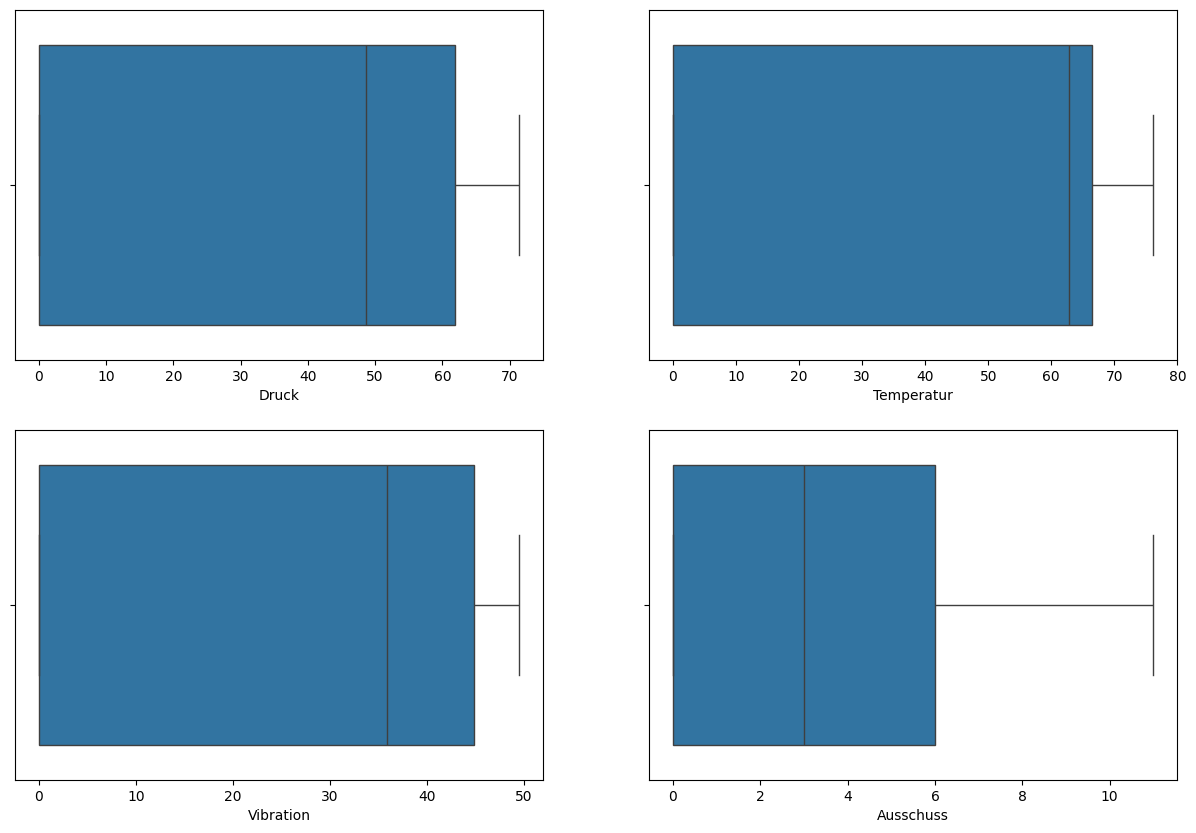

In [22]:
#Ausreißer überprüfen
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(x=d2['Druck'], ax=ax[0,0])
sns.boxplot(x=d2['Temperatur'], ax=ax[0,1])
sns.boxplot(x=d2['Vibration'], ax=ax[1,0])
sns.boxplot(x=d2['Ausschuss'], ax=ax[1,1])
plt.show()

In [23]:
d4 = d2.copy()
d3 = d2.copy()

In [24]:
#irrelevante spalten entfernen
spalten_zu_behalten = [col for col in d4.columns if col not in ['Datum', 'Zeit', 'Produktionsindex', 'MaschinenID', 'MesswertID']]

# Filtern des DataFrames, um nur die gewünschten Spalten zu behalten
d4 = d4[spalten_zu_behalten]


In [25]:
print(d4.info())

<class 'dask.dataframe.core.DataFrame'>
Columns: 6 entries, Druck to Ausfall
dtypes: float64(4), int32(1), int64(1)None


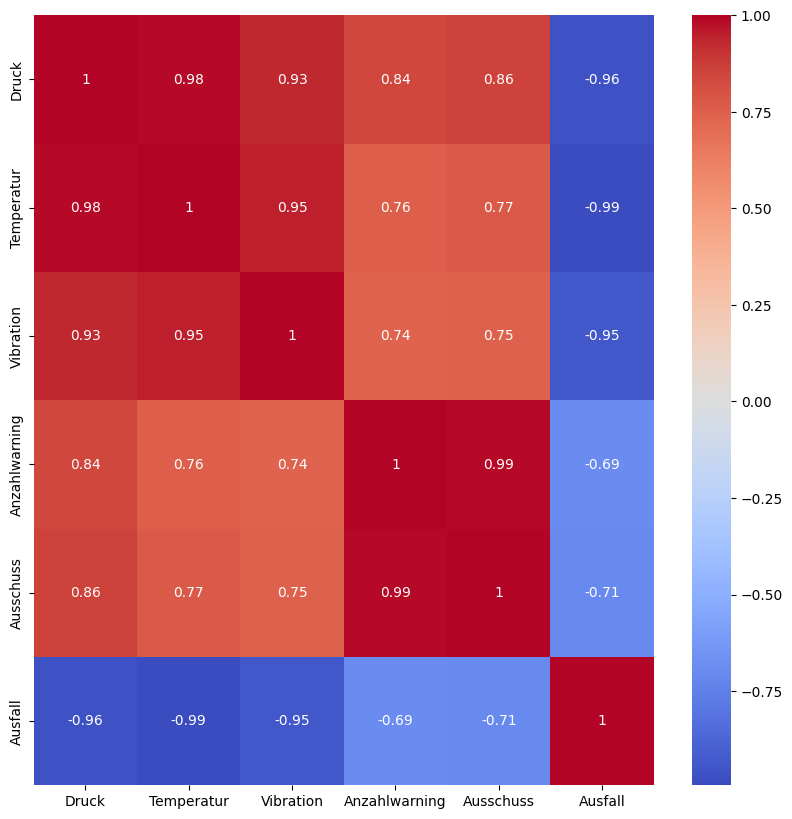

In [26]:
#korrelationen anzeigen
correlation = d4.corr().compute()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

#### Rollender Mittelwert:

In [27]:
#rollender mittelwert hinzufügen
d4['Druck_rolling'] = d3['Druck'].rolling(window=12).mean()
d4['Vibration_rolling'] = d3['Vibration'].rolling(window=12).mean()
d4['Temperatur_rolling'] = d3['Temperatur'].rolling(window=12).mean()
d4['Ausschuss_rolling'] = d3['Ausschuss'].rolling(window=12).mean()
d4['Anzahlwarning_rolling'] = d3['Anzahlwarning'].rolling(window=12).mean()

In [28]:
#rollende standardabweichung hinzufügen
d4['Druck_std'] = d3['Druck'].rolling(window=12).std()
d4['Vibration_std'] = d3['Vibration'].rolling(window=12).std()
d4['Temperatur_std'] = d3['Temperatur'].rolling(window=12).std()
d4['Anzahlwarning_std'] = d3['Anzahlwarning'].rolling(window=12).std()

In [29]:
#andere spalten entfernen
spalten_zu_behalten = [col for col in d4.columns if col not in ['Druck', 'Vibration', 'Temperatur', 'Ausschuss',"Anzahlwarning"]]

# Filtern des DataFrames, um nur die gewünschten Spalten zu behalten
d4 = d4[spalten_zu_behalten]
d4.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 10 entries, Ausfall to Anzahlwarning_std
dtypes: float64(9), int32(1)

In [30]:
#fill NaN values with 0
d4 = d4.fillna(0)

In [31]:
#entfernen der Zeilen mit 0 werten Druck_rolling, Vibration_rolling, Temperatur_rolling, Ausschuss_rolling, Anzahlwarning_rolling aufgrund von rolling mean
d4 = d4[d4['Druck_rolling'] != 0]
d4 = d4[d4['Vibration_rolling'] != 0]
d4 = d4[d4['Temperatur_rolling'] != 0]
d4 = d4[d4['Ausschuss_rolling'] != 0]
d4 = d4[d4['Anzahlwarning_rolling'] != 0]


In [32]:
print(type(d4))

<class 'dask.dataframe.core.DataFrame'>


In [33]:
#Zielvariabl und Features trennen
y = d4['Ausfall']  #Zielvariable

spalten_zu_behalten = [col for col in d4.columns if col not in ['Ausfall']]
X = d4[spalten_zu_behalten] #Features

In [47]:
print(type(y))
print(type(X))

<class 'dask.dataframe.core.Series'>
<class 'dask.dataframe.core.DataFrame'>


In [35]:
import dask.array as da
from dask_ml.model_selection import train_test_split
#train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=69)


In [36]:
#Dask Dataframes in Dask Arrays umwandeln
if isinstance(X_train, dd.DataFrame):
    X_train = X_train.values
if isinstance(X_test, dd.DataFrame):
    X_test = X_test.values

if isinstance(y_train, dd.Series):
    y_train = y_train.values
if isinstance(y_test, dd.Series):
    y_test = y_test.values

In [37]:
#chunk größen berechnen zum bearbeiten der Modelle
X_test = X_test.compute_chunk_sizes()
y_test = y_test.compute_chunk_sizes()

## Parallele Berechnung für eine Logistische Regression

In [38]:
#trainieren des Logistischen Regressionsmodells
from dask_ml.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
#Ergebnisse ausgeben
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       161
           1       0.47      0.48      0.48        54

    accuracy                           0.73       215
   macro avg       0.65      0.65      0.65       215
weighted avg       0.74      0.73      0.74       215

